In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


import torch.nn as nn
import torch.optim as optim

import numpy as np

In [1]:
import pandas as pd

# Cargar los archivos usando el separador "::"
movies_path = "ml-1m/movies.dat"
ratings_path = "ml-1m/ratings.dat"
users_path = "ml-1m/users.dat"

movies = pd.read_csv(movies_path, sep="::", engine="python", header=None, encoding="latin-1")
ratings = pd.read_csv(ratings_path, sep="::", engine="python", header=None)
users = pd.read_csv(users_path, sep="::", engine="python", header=None)

# Asignar nombres de columnas
movies.columns = ["MovieID", "Title", "Genres"]
ratings.columns = ["UserID", "MovieID", "Rating", "Timestamp"]
users.columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]

# Primeras filas de cada dataset
movies.head(), ratings.head(), users.head()


(   MovieID                               Title                        Genres
 0        1                    Toy Story (1995)   Animation|Children's|Comedy
 1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
 2        3             Grumpier Old Men (1995)                Comedy|Romance
 3        4            Waiting to Exhale (1995)                  Comedy|Drama
 4        5  Father of the Bride Part II (1995)                        Comedy,
    UserID  MovieID  Rating  Timestamp
 0       1     1193       5  978300760
 1       1      661       3  978302109
 2       1      914       3  978301968
 3       1     3408       4  978300275
 4       1     2355       5  978824291,
    UserID Gender  Age  Occupation Zip-code
 0       1      F    1          10    48067
 1       2      M   56          16    70072
 2       3      M   25          15    55117
 3       4      M   45           7    02460
 4       5      M   25          20    55455)

/tmp/ipykernel_11275/4021565379.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_dist.index, y=rating_dist.values, ax=axs[0, 0], palette='viridis')
/tmp/ipykernel_11275/4021565379.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=axs[1, 0], palette='cubehelix')
/tmp/ipykernel_11275/4021565379.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_movies.values, y=popular_titles, ax=axs[1, 1], palette='Blues_d')


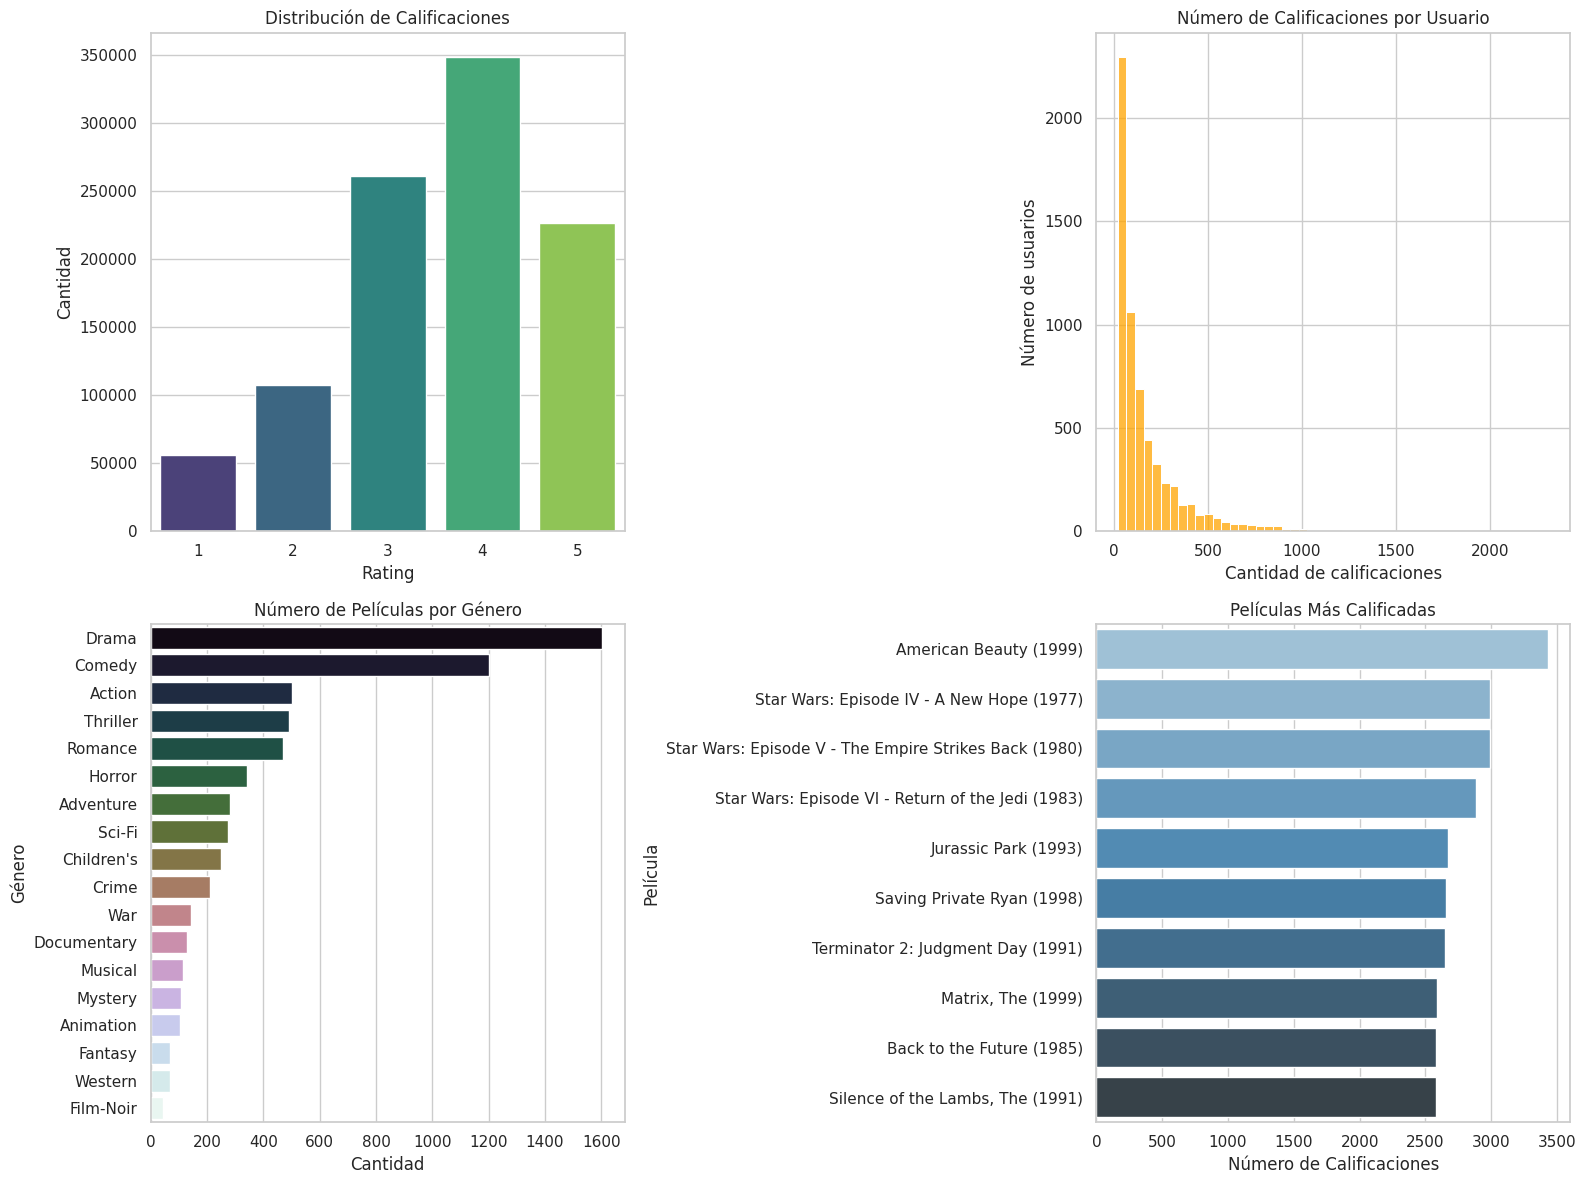

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Distribución de calificaciones
rating_dist = ratings['Rating'].value_counts().sort_index()

# Ratings por película y por usuario
ratings_per_movie = ratings.groupby('MovieID').size()
ratings_per_user = ratings.groupby('UserID').size()

# Estadísticas de usuario
user_stats = users['Age'].value_counts().sort_index()

# Películas más populares (más veces calificadas)
popular_movies = ratings_per_movie.sort_values(ascending=False).head(10)

# Distribución de géneros
genre_list = movies['Genres'].str.split('|').explode()
genre_counts = genre_list.value_counts()

# Plot distribución de calificaciones
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(x=rating_dist.index, y=rating_dist.values, ax=axs[0, 0], palette='viridis')
axs[0, 0].set_title("Distribución de Calificaciones")
axs[0, 0].set_xlabel("Rating")
axs[0, 0].set_ylabel("Cantidad")

sns.histplot(ratings_per_user, bins=50, kde=False, ax=axs[0, 1], color='orange')
axs[0, 1].set_title("Número de Calificaciones por Usuario")
axs[0, 1].set_xlabel("Cantidad de calificaciones")
axs[0, 1].set_ylabel("Número de usuarios")

sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=axs[1, 0], palette='cubehelix')
axs[1, 0].set_title("Número de Películas por Género")
axs[1, 0].set_xlabel("Cantidad")
axs[1, 0].set_ylabel("Género")

popular_titles = movies.set_index("MovieID").loc[popular_movies.index, "Title"]
sns.barplot(x=popular_movies.values, y=popular_titles, ax=axs[1, 1], palette='Blues_d')
axs[1, 1].set_title("Películas Más Calificadas")
axs[1, 1].set_xlabel("Número de Calificaciones")
axs[1, 1].set_ylabel("Película")

plt.tight_layout()
plt.show()


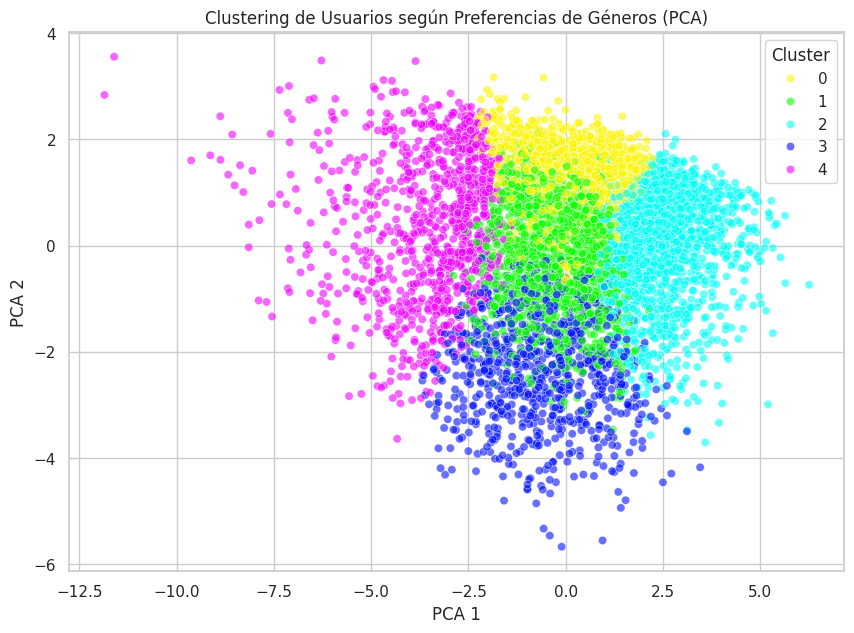

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Para clustering, vamos a crear una matriz usuario-película
# Pero esta sería muy dispersa, así que vamos a usar usuario -> promedio de rating por género

# Expandir géneros
movies_expanded = movies.copy()
movies_expanded['Genres'] = movies_expanded['Genres'].str.split('|')
movies_expanded = movies_expanded.explode('Genres')

# Merge ratings con películas y luego con usuarios
merged = ratings.merge(movies_expanded, on='MovieID').merge(users, on='UserID')

# Pivot table: Usuario x Género con promedio de ratings
user_genre_matrix = merged.pivot_table(index='UserID', columns='Genres', values='Rating', aggfunc='mean').fillna(0)

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_genre_matrix)

# Reducir dimensionalidad para visualizar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plot
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", 5)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette=palette, alpha=0.6)
plt.title("Clustering de Usuarios según Preferencias de Géneros (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert ratings to implicit feedback (1 if rating >= 4, else 0)
ratings['Interaction'] = (ratings['Rating'] >= 4).astype(np.float32)

# Create user-item pairs
user_item_pairs = ratings[['UserID', 'MovieID', 'Interaction']]

# Map UserID and MovieID to indices (PyTorch requires indices starting from 0)
user_mapping = {user_id: idx for idx, user_id in enumerate(user_item_pairs['UserID'].unique())}
item_mapping = {movie_id: idx for idx, movie_id in enumerate(user_item_pairs['MovieID'].unique())}

user_item_pairs['UserID'] = user_item_pairs['UserID'].map(user_mapping)
user_item_pairs['MovieID'] = user_item_pairs['MovieID'].map(item_mapping)

# Train-test split
train_data, test_data = train_test_split(user_item_pairs, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_users = torch.tensor(train_data['UserID'].values, dtype=torch.long)
train_items = torch.tensor(train_data['MovieID'].values, dtype=torch.long)
train_labels = torch.tensor(train_data['Interaction'].values, dtype=torch.float32)

test_users = torch.tensor(test_data['UserID'].values, dtype=torch.long)
test_items = torch.tensor(test_data['MovieID'].values, dtype=torch.long)
test_labels = torch.tensor(test_data['Interaction'].values, dtype=torch.float32)

/tmp/ipykernel_11275/1597993075.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_pairs['UserID'] = user_item_pairs['UserID'].map(user_mapping)
/tmp/ipykernel_11275/1597993075.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_pairs['MovieID'] = user_item_pairs['MovieID'].map(item_mapping)


In [8]:
import torch
import torch.nn as nn

class NeuralCollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(NeuralCollaborativeFiltering, self).__init__()
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # MLP layers
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, user_ids, item_ids):
        # Get embeddings
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        
        # Concatenate embeddings
        x = torch.cat([user_embeds, item_embeds], dim=-1)
        
        # Pass through MLP
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        
        return x

In [12]:
import matplotlib.pyplot as plt

# Initialize model, loss, and optimizer
num_users = len(user_mapping)
num_items = len(item_mapping)
model = NeuralCollaborativeFiltering(num_users, num_items)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for implicit feedback
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
batch_size = 256
loss_history = []  # To store loss for each epoch

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    # Mini-batch training
    for i in range(0, len(train_users), batch_size):
        batch_users = train_users[i:i+batch_size]
        batch_items = train_items[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        
        # Forward pass
        predictions = model(batch_users, batch_items).squeeze()
        loss = criterion(predictions, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Store average loss for the epoch
    avg_loss = epoch_loss / len(train_users)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.0023
Epoch 2/10, Loss: 0.0021
Epoch 3/10, Loss: 0.0021
Epoch 4/10, Loss: 0.0021
Epoch 5/10, Loss: 0.0020
Epoch 6/10, Loss: 0.0020
Epoch 7/10, Loss: 0.0020
Epoch 8/10, Loss: 0.0020
Epoch 9/10, Loss: 0.0020
Epoch 10/10, Loss: 0.0019


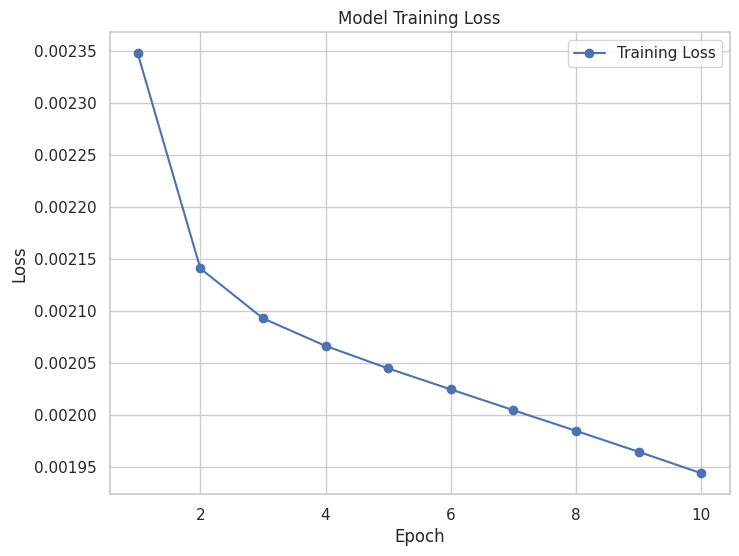

In [13]:
# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import roc_auc_score

model.eval()
with torch.no_grad():
    predictions = model(test_users, test_items).squeeze()
    auc = roc_auc_score(test_labels.numpy(), predictions.numpy())
    print(f"Test AUC: {auc:.4f}")

Test AUC: 0.7797


In [11]:
def recommend_movies(user_id, top_k=10):
    user_idx = user_mapping[user_id]
    all_items = torch.arange(num_items)
    
    model.eval()
    with torch.no_grad():
        scores = model(torch.tensor([user_idx] * num_items), all_items).squeeze()
    
    # Get top-k items
    top_items = torch.topk(scores, top_k).indices.numpy()
    recommended_movie_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(i)] for i in top_items]
    
    return recommended_movie_ids

# Example: Recommend movies for user 1
recommendations = recommend_movies(user_id=1, top_k=5)
print("Recommended Movie IDs:", recommendations)

Recommended Movie IDs: [np.int64(2503), np.int64(3435), np.int64(904), np.int64(3849), np.int64(3338)]
